In [320]:
from datetime import datetime, timedelta
from collections import defaultdict
from time import time
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tweepy

In [2]:
#inputs
bearer_token = "AAAAAAAAAAAAAAAAAAAAAH4BlAEAAAAA3Dd4SGtdK%2FWbAqlEdIcXzoPB4%2BA%3DwDjEbymhTQgnmvHM8Vvetae79bgdBz1eyHWSyXZVqRnCCir1nA" #mpolo
limit = 2 #number of requests of `max_results` tweets each

In [3]:
#create paginator
client = tweepy.Client(bearer_token)
paginator = tweepy.Paginator( #TODO vedi come filtrare via tutti i tweet con media file
    method=client.search_recent_tweets,
    limit=limit,
    query=(
        '(context:131.825047692124442624 OR context:152.825047692124442624) ' #https://github.com/twitterdev/twitter-context-annotations
        '-is:retweet ' #TODO check and search doc for other usefull operators
        'lang:en'),
    end_time=datetime.utcnow()-timedelta(days=6), #go backwards starting from 6 days ago
    expansions=['author_id'], #TODO search doc for other usefull expansions
    max_results=100, #500 if academic research access
    tweet_fields=['public_metrics'], #TODO search doc for other usefull tweet fields
    user_fields=['public_metrics']) #TODO search doc for usefull user fields

#download tweets
data = defaultdict(list)
for response in paginator:
    for tweet, user in zip(response.data, response.includes['users']):
        if tweet.author_id == user.id: #some don't match for no reason
            data['text'] += [tweet.text]
            data['likes'] += [tweet.public_metrics['like_count']]
            data['followers'] += [user.public_metrics['followers_count']]

#save tweets
os.makedirs('debug_sets', exist_ok=True)
set_id = int(time() % 1e6) #unique for 11 days
pd.DataFrame(data).to_csv(f'debug_sets/{set_id}.csv', index=False)
set_id

409165

TODO `search_recent_tweets` is up to 7 days. To search further back, use [search_all_tweets](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_all_tweets) instead (and add `start_time` parameter). But it needs the [academic research access](https://developer.twitter.com/en/docs/projects). It also increases the monthly cap from 500,000 to 10 million.

In [583]:
#load tweets
set_id = 407729
df = pd.read_csv(f'debug_sets/{set_id}.csv')
df['likes'] += 1 #start likes from 1 for simplicity
df['followers'] += 1 #start followers from 1 for simplicity
df.head(2)

,text,likes,followers
0,I guess I had too much soju and ume on a weekd...,1.0,40.0
1,"Egyptian rice, tuna, ground beef, onions, and ...",3.0,91.0


array([0.21266962])

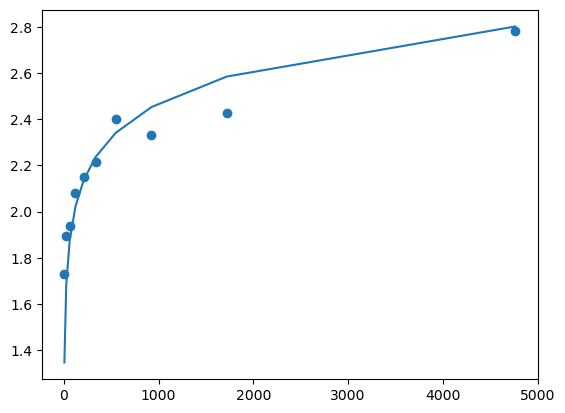

In [588]:
#remove outliers TODO tune q (eg.: 0.95)
q = df.quantile(0.95, numeric_only=True) #numeric_only to fix warning
df_q = df[(df['likes'] < q['likes']) & (df['followers'] < q['followers'])].copy() #copy to fix warning

#group by followers TODO tune number of groups (eg.: 10)
df_q.sort_values(by='followers', inplace=True, ignore_index=True)
df_q['group'] = df_q.index//(len(df_q)/10) #groups of same size
df_q = df_q.groupby('group').mean(numeric_only=True) #numeric_only to fix warning

#plot average followers vs average likes
x = df_q['followers']
y = df_q['likes']
plt.scatter(x, y)

#fit log curve and plot it
def curve(x, coeff):
    return 1 + coeff * np.log(x) #not log1p for simplicity
coeff, _ = curve_fit(curve, xdata=x, ydata=y)
plt.plot(x, curve(x, coeff))
coeff

TODO togli tweet con immagini ecc.

TODO studia query [qua](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query)
    * continua a studiare link al tutorial "Building high-quality..." (da "Example queries & rules")
        * finora interessante solo:
            * link ad [annotations](https://developer.twitter.com/en/docs/twitter-api/annotations/overview)
            * In the new Twitter API (recent search and filtered stream), AND is applied before OR

verifica quello che dice chatGPT (i like invece credo li abbia solo il tweet originale):
"When you search for tweets using Tweepy, you will get the original tweet and any retweeted versions of that tweet as separate results. Retweets are considered to be separate tweets from the original, so you will receive multiple results for the same content if it has been retweeted multiple times. To avoid receiving duplicate results, you can use the .dedup() method of the Cursor object to remove duplicates. This will only return one result for each unique tweet, even if it has been retweeted multiple times."

inoltre like sempre a [zero se è retweet](https://twittercommunity.com/t/tweets-having-likes-more-than-zero-always-shows-zero-while-on-twitter-it-shows-more-than-zero-likes-it-only-shows-retweets-counts-accurate-please-tell-me-how-to-get-the-correct-like-count-as-well-i-am-using-twitter-v2-search-api/160840/4)

In [617]:
#get popularity by normalizing likes
df['popularity'] = df['likes']/curve(df['followers'], coeff)

#assign popularity level
df.sort_values(by='popularity', inplace=True, ignore_index=True)
df['pop_level'] = df.index//(len(df)/3) #groups of same size
df

,text,likes,followers,popularity,pop_level
0,@FoodLiesOrg There was barely any processed fo...,1.0,6949712.0,0.229862,0.0
1,Photo By pixel2013 | Pixabay \n #macarons #ros...,1.0,5247908.0,0.233062,0.0
2,@BigOtrivia If Australia was at 56 for 4 at lu...,1.0,1000447.0,0.253921,0.0
3,We’re serving up some Capital Punishment in Bi...,1.0,702746.0,0.258858,0.0
4,CTSZOOM Electric Lunch Box Food Warmer for Car...,1.0,660248.0,0.259750,0.0
...,...,...,...,...,...
9482,I went out to visit some friends today for lun...,1325.0,361.0,588.265215,2.0
9483,@BadLipReading @MarcACaputo Omg poor AOC she’s...,1866.0,1392.0,734.816829,2.0
9484,Meet Me On Your Lunch Break 🤭 https://t.co/9Es...,2802.0,191840.0,781.153750,2.0
9485,I saw the guy that owns Freddy's leave on his ...,22611.0,111.0,11296.609614,2.0


TODO imo vedi grafico sopra (quello dove fitti il log) e vedi a quanti follower ci si aspetta almeno un like (2 visto che uno lo hai regalato). Elimina tutti i tweet con zero like  (1 visto che...) e meno follower perché non danno informazioni.
Cioè se ha pochissimi follower e cmq 2 like allora sai che buono, ma se ha 1 like e boh tipo 20 follower non puoi dire che il tweet fa schifo visto che non ci si aspetta più like comunque. Cioè son praticamente delle osservazioni senza label e quindi vanno tolte. Pensa anche a 1 like e 1 follower (entrambi regalati), viene popularity 1 cioé nella media ma in verità non si può giudicare. O forse boh van bene lo stesso perché spostano gli altri (cioé fanno scalare di classe quelli con stesso numero di like e più follower, che ci sta). pensaci. intanto lasciali per semplicità